# **1. Import thư viện**

In [1]:
!pip install xgboost

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, \
                            roc_auc_score, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns

# **2. Chuẩn bị dữ liệu**

In [2]:
# Tải dữ liệu
df = pd.read_csv('ECommerce_Dataset_cleaned_model.csv')

In [3]:
df.head()

,Churn,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,DaySinceLastOrder,CashbackAmount,DevicePerTenure
0,1,3,6,3,3,Laptop & Accessory,2,Single,9,1,11,1,5,160,0.75
1,1,1,8,3,4,Mobile Phone,3,Single,7,1,15,0,0,121,4.00
2,1,1,30,2,4,Mobile Phone,3,Single,6,1,14,0,3,120,4.00
3,1,3,15,2,4,Laptop & Accessory,5,Single,8,0,23,0,3,134,4.00
4,1,1,12,3,3,Mobile Phone,5,Single,3,0,11,1,3,130,3.00


In [4]:
# Xác định biến đầu vào và mục tiêu
target = 'Churn'

X = df.drop(columns=[target])
y = df[target]

In [5]:
# Xác định cột định lượng (numeric) và định tính (categorical)
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# **3. Tạo Pipeline (Tiền xử lý + Mô hình)**

In [6]:
# ColumnTransformer: One-Hot Encoding + Scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)

In [7]:
# Xây dựng model
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

model = XGBClassifier(
    n_estimators=300,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    random_state=42,
    n_jobs=-1
)

In [8]:
# Xây dựng Pipeline
clf = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])

In [9]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# **4. Cross validation (10-fold)**

In [10]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

y_pred_cv = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict')
y_proba_cv = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

roc_auc_cv = roc_auc_score(y_train, y_proba_cv)
print(f"CV ROC-AUC: {roc_auc_cv:.5f}")
print("\nClassification Report (Cross-Validation on Train):")
print(classification_report(y_train, y_pred_cv))

CV ROC-AUC: 0.97604

Classification Report (Cross-Validation on Train):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3746
           1       0.91      0.88      0.89       758

    accuracy                           0.97      4504
   macro avg       0.94      0.93      0.94      4504
weighted avg       0.96      0.97      0.96      4504



# **5. Huấn luyện & dự đoán**

In [11]:
# Train model
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CityTier',
                                                   'WarehouseToHome',
                                                   'HourSpendOnApp',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'Complain',
                                                   'OrderAmountHikeFromlastYear',
                                                   'CouponUsed',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount',
                                                   'DevicePerTenure']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [12]:
# Dự đoán
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

# **6. Đánh giá mô hình**

In [13]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       936
           1       0.97      0.95      0.96       190

    accuracy                           0.99      1126
   macro avg       0.98      0.97      0.98      1126
weighted avg       0.99      0.99      0.99      1126



### **Nhận xét:**

- Mô hình đạt **accuracy = 99%**, cho thấy hiệu suất phân loại tổng thể rất cao trên tập dữ liệu kiểm tra. Đối với **lớp churn (1)**, mô hình đạt **recall = 0.95**, chứng tỏ khả năng phát hiện phần lớn khách hàng có nguy cơ rời bỏ, chỉ bỏ sót một tỷ lệ nhỏ. Đây là yếu tố quan trọng trong bài toán churn, nơi việc không phát hiện được khách hàng rời đi thường gây thiệt hại lớn hơn so với dự đoán nhầm.

- Đồng thời, **precision = 0.97** ở lớp churn cho thấy các dự đoán churn có độ tin cậy cao, hạn chế việc cảnh báo sai không cần thiết. Các chỉ số **macro F1 = 0.98** và **weighted F1 = 0.99** phản ánh mô hình hoạt động ổn định trên dữ liệu có sự mất cân bằng giữa các lớp, không bị thiên lệch bởi lớp chiếm đa số.


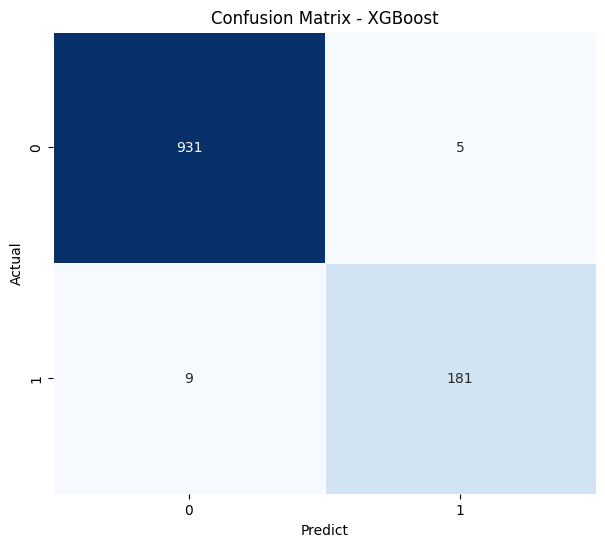

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar=False, linewidths=0.5)
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

### **Nhận xét:**

* Phát hiện chính xác **181 khách hàng sẽ rời bỏ**, góp phần nâng cao hiệu quả cho các chiến dịch giữ chân khách hàng.
* Xác định đúng **931 khách hàng trung thành**, giúp doanh nghiệp tránh lãng phí nguồn lực chăm sóc không cần thiết.
* Số lượng lỗi:
    * Lỗi bỏ sót khách hàng rời bỏ (False Negative): **9 trường hợp**.
    * Lỗi báo nhầm khách hàng rời bỏ (False Positive): **5 trường hợp**.
* **Kết luận:** Mô hình hoạt động **ổn định và đáng tin cậy**, với tỷ lệ dự đoán chính xác cao ở cả hai lớp. Đặc biệt, số lượng **bỏ sót khách hàng rời bỏ ở mức thấp**, cho thấy mô hình đáp ứng tốt mục tiêu chính của bài toán churn là ưu tiên phát hiện khách hàng có nguy cơ rời đi.


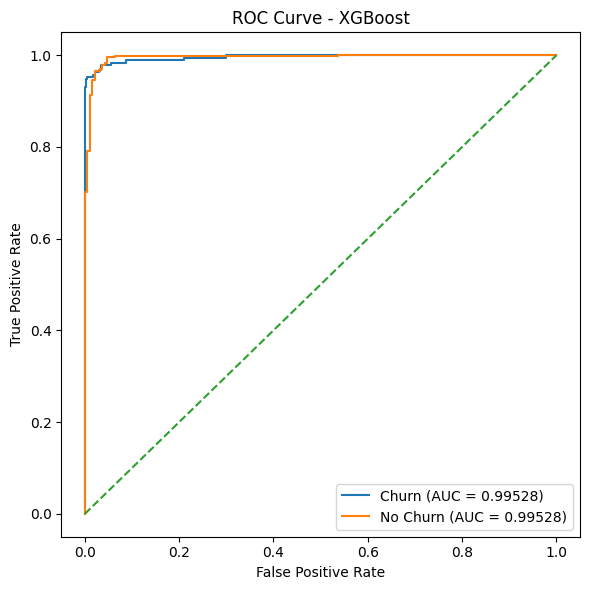

In [15]:
# vẽ ROC Curve

# Lớp churn = 1
fpr_1, tpr_1, _ = roc_curve(y_test, y_proba[:, 1])
auc_1 = auc(fpr_1, tpr_1)

# Lớp churn = 0
fpr_0, tpr_0, _ = roc_curve(1 - y_test, y_proba[:, 0])
auc_0 = auc(fpr_0, tpr_0)

plt.figure(figsize=(6, 6))
plt.plot(fpr_1, tpr_1, label=f'Churn (AUC = {auc_1:.5f})')
plt.plot(fpr_0, tpr_0, label=f'No Churn (AUC = {auc_0:.5f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.tight_layout()
plt.show()

**Nhận xét:**

* Với **AUC = 0.99528**, mô hình thể hiện khả năng **phân biệt hai nhóm khách hàng ở mức rất cao**, cho thấy hiệu quả dự đoán vượt trội.
* Đường ROC bám sát vùng góc trên bên trái phản ánh sự **cân bằng tốt giữa khả năng phát hiện khách hàng rời bỏ và việc hạn chế dự đoán sai**, giúp mô hình vừa nhạy vừa ổn định trong quá trình phân loại.
